# Pascal VOC - Multi label classification

In [3]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [4]:
from fastai.conv_learner import *
from fastai.dataset import *

import json, pdb
from PIL import ImageDraw, ImageFont
from matplotlib import patches, patheffects
torch.cuda.set_device(0)

In [5]:
torch.backends.cudnn.benchmark = True

## Setup

In [15]:
print("categories json:", trn_j[CATEGORIES][0])
print("images json:", trn_j[IMAGES][0])
print("annotations json:", trn_j[ANNOTATIONS][0])

categories json: {'supercategory': 'none', 'id': 1, 'name': 'aeroplane'}
images json: {'file_name': '000012.jpg', 'height': 333, 'width': 500, 'id': 12}
annotations json: {'segmentation': [[155, 96, 155, 270, 351, 270, 351, 96]], 'area': 34104, 'iscrowd': 0, 'image_id': 12, 'bbox': [155, 96, 196, 174], 'category_id': 7, 'id': 1, 'ignore': 0}


In [8]:
PATH = Path('data/pascal')
trn_j = json.load((PATH / 'pascal_train2007.json').open())
IMAGES, ANNOTATIONS, CATEGORIES = ['images', 'annotations', 'categories']
FILE_NAME, ID, IMG_ID, CAT_ID, BBOX = 'file_name', 'id', 'image_id', 'category_id', 'bbox'

In [16]:
cats = dict((o[ID], o['name']) for o in trn_j[CATEGORIES])
trn_fns = dict((o[ID], o[FILE_NAME]) for o in trn_j[IMAGES])
trn_ids = [o[ID] for o in trn_j[IMAGES]]

In [21]:
print(len(cats), len(trn_fns), len(trn_ids))

20 2501 2501


In [22]:
JPEGS = 'VOCdevkit/VOC2007/JPEGImages'
IMG_PATH = PATH / JPEGS

In [23]:
IMG_PATH

PosixPath('data/pascal/VOCdevkit/VOC2007/JPEGImages')

In [29]:
!ls {str(IMG_PATH)} | wc -l

5011


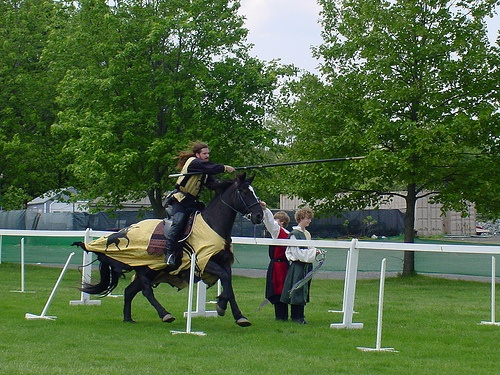

In [28]:
# DEBUG: try to show an image from the dataset in file system
from IPython.display import Image
Image(filename=str(IMG_PATH / '000009.jpg'))

In [30]:
def hw_bb(bb):
    # Example, bb = [155, 96, 196, 174]
    return np.array([ bb[1], bb[0], bb[3] + bb[1] - 1, bb[2] + bb[0] - 1 ])

In [31]:
def get_trn_anno():
    trn_anno = collections.defaultdict(lambda:[])

    for o in trn_j[ANNOTATIONS]:
        if not o['ignore']:
            bb = o[BBOX] # one bbox. looks like '[155, 96, 196, 174]'.
            bb = hw_bb(bb)
            trn_anno[o[IMG_ID]].append( (bb, o[CAT_ID]) )
    return trn_anno

In [42]:
trn_anno = get_trn_anno()
len(trn_anno)

2501

In [32]:
def show_img(im, figsize=None, ax=None):
    if not ax:
        fig, ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
    # ax.get_xaxis().set_visible(False)
    # ax.get_yaxis().set_visible(False)
    ax.set_xticks(np.linspace(0, 224, 8))
    ax.set_yticks(np.linspace(0, 224, 8))
    ax.grid()
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    return ax

In [33]:
def draw_outline(o, lw):
    o.set_path_effects( [patheffects.Stroke(linewidth=lw, foreground='black'),
                          patheffects.Normal()] )

In [34]:
def draw_rect(ax, b, color='white'):
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor=color, lw=2))
    draw_outline(patch, 4)

In [35]:
def draw_text(ax, xy, txt, sz=14, color='white'):
    text = ax.text(*xy, txt, verticalalignment='top', color=color, fontsize=sz, weight='bold')
    draw_outline(text, 1)

In [36]:
def bb_hw(a):
    return np.array( [ a[1], a[0], a[3] - a[1] + 1, a[2] - a[0] + 1 ] )

In [37]:
def draw_im(im, ann):
    # im is image, ann is annotations
    ax = show_img(im, figsize=(16, 8))
    for b, c in ann:
        # b is bbox, c is class id
        b = bb_hw(b)
        draw_rect(ax, b)
        draw_text(ax, b[:2], cats[c], sz=16)

In [38]:
def draw_idx(i):
    # i is image id
    im_a = trn_anno[i] # training annotations
    im = open_image(IMG_PATH / trn_fns[i]) # trn_fns is training image file names
    draw_im(im, im_a) # im_a is an element of annotation

## Multi class

In [39]:
MC_CSV = PATH / 'tmp/mc.csv'

In [43]:
trn_anno[12]

[(array([ 96, 155, 269, 350]), 7)]

In [44]:
mc = [ set( [cats[p[1]] for p in trn_anno[o] ] ) for o in trn_ids ]
mcs = [ ' '.join( str(p) for p in o ) for o in mc ] # stringify mc

In [51]:
print('mc:', mc[1])
print('mcs:', mcs[1])

mc: {'horse', 'person'}
mcs: horse person


In [ ]:
df = pd.DataFrame({'fn': [trn_fns[o] for o in trn_ids], 'clas': mcs}, columns=['fn','clas'])
df.to_csv(MC_CSV, index=False)

In [52]:
df = pd.DataFrame({ 'fn': [trn_fns[o] for o in trn_ids], 'clas': mcs }, columns=['fn', 'clas'])
df.to_csv(MC_CSV, index=False)

In [54]:
# DEBUG: Check CSV file is created
!ls {str(PATH)}/tmp/

bb.csv	lrg.csv  mc.csv


In [55]:
# DEBUG: View CSV data
!head -n 10 {str(PATH)}/tmp/mc.csv

fn,clas
000012.jpg,car
000017.jpg,horse person
000023.jpg,person bicycle
000026.jpg,car
000032.jpg,person aeroplane
000033.jpg,aeroplane
000034.jpg,train
000035.jpg,person
000036.jpg,dog


### Model

In [57]:
f_model = resnet34
sz = 224
bs = 64

In [58]:
tfms = tfms_from_model(f_model, sz, crop_type=CropType.NO)
md = ImageClassifierData.from_csv(PATH, JPEGS, MC_CSV, tfms=tfms, bs=bs)

In [60]:
learn = ConvLearner.pretrained(f_model, md)
learn.opt_fn = optim.Adam

In [61]:
lrf = learn.lr_find(1e-5, 100)

epoch      trn_loss   val_loss   <lambda>                  
    0      1.705616   11.417138  0.5868    



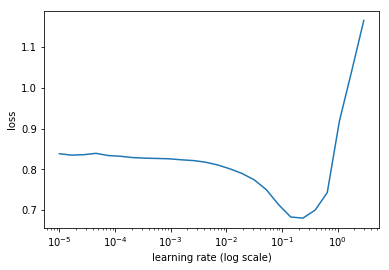

In [62]:
learn.sched.plot(0)

In [63]:
lr = 2e-2

In [64]:
learn.fit(lr, 1, cycle_len=3, use_clr=(32, 5))

epoch      trn_loss   val_loss   <lambda>                  
    0      0.319539   0.139347   0.9535    
    1      0.172275   0.080689   0.9724                    
    2      0.116136   0.075965   0.975                     



[array([0.07597]), 0.9750000004768371]

In [65]:
lrs = np.array([lr/100, lr/10, lr])

In [66]:
learn.freeze_to(-2)

 84%|████████▍ | 27/32 [00:13<00:02,  2.07it/s, loss=0.464] 

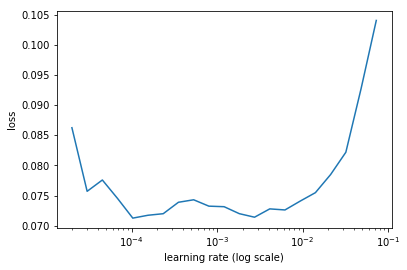

In [67]:
learn.lr_find(lrs/1000)
learn.sched.plot(0)

In [68]:
learn.fit(lrs/10, 1, cycle_len=5, use_clr=(32, 5))

epoch      trn_loss   val_loss   <lambda>                   
    0      0.071997   0.078266   0.9734    
    1      0.055321   0.082668   0.9737                     
    2      0.040407   0.077682   0.9757                     
    3      0.027939   0.07651    0.9756                     
    4      0.019983   0.07676    0.9763                     


[array([0.07676]), 0.9763000016212463]

In [69]:
learn.save('mclas')

In [70]:
learn.load('mclas')

### Evaluate

In [71]:
y = learn.predict()
x, _ = next(iter(md.val_dl))
x = to_np(x)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


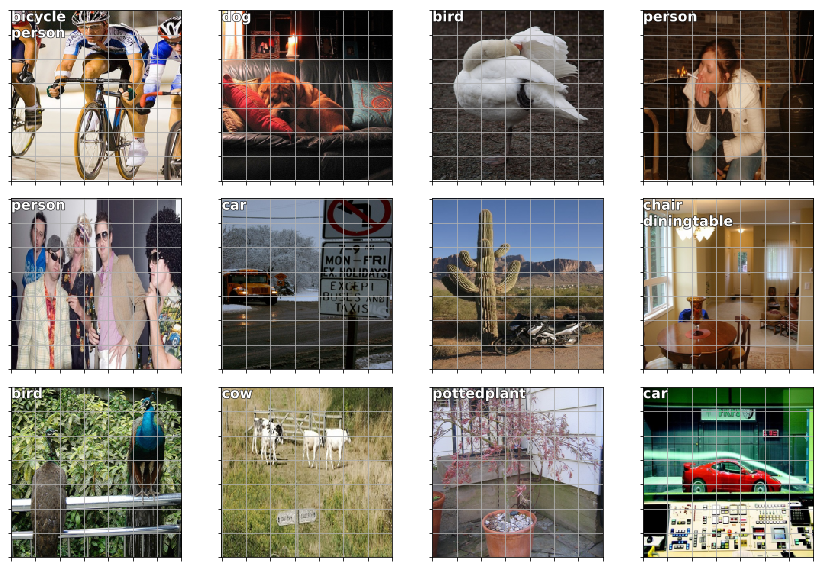

In [72]:
fig, axes = plt.subplots(3, 4, figsize=(12, 8))

for i, ax in enumerate(axes.flat):
    ima = md.val_ds.denorm(x)[i]
    ya = np.nonzero(y[i] > 0.4)[0]
    b = '\n'.join(md.classes[o] for o in ya)
    ax = show_img(ima, ax=ax)
    draw_text(ax, (0, 0), b)
plt.tight_layout()